In [1]:
%matplotlib inline
#%pylab
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mpc
import matplotlib.dates as dts
import numpy as np
import math
#import pandas as pd
import itertools
import os
#import ROOT
import datetime
#from root_numpy import root2array, root2rec, tree2rec, array2root
from scipy.optimize import curve_fit
from scipy.misc import factorial
plt.rcParams.update({'font.size': 16})

In [2]:
from decode import GetWaveforms
from decode import GetWaveformsNoiseRemoval

In [3]:
from datetime import datetime

In [157]:
# gas run 2
#PATH = '/Users/davidc/Downloads/Gas_15psi/measures/'
# liquid run 2
#PATH = '/Users/davidc/Downloads/LiquidArgon/VC200_VCG130/measures/'
# liquid run 1
#PATH = '/Users/davidc/Downloads/RUN1/measures/'
#gas run 3
PATH = '/Users/davidc/Downloads/RUN3/3psi/data/'
datafile_v = os.listdir(PATH)
print(datafile_v)
dt = 0.0005
datafile_v.sort()
print(datafile_v)
RC=0.240

['PrM1-2018_09_18-11_12_14.dat', 'PrM1-2018_09_18-10_22_17.dat', 'PrM1-2018_09_18-11_07_21.dat', 'PrM1-2018_09_18-11_42_19.dat', 'PrM1-2018_09_18-13_35_05.dat', 'PrM1-2018_09_18-10_37_30.dat', 'PrM1-2018_09_18-13_20_09.dat', 'PrM1-2018_09_18-10_27_20.dat', 'PrM1-2018_09_18-11_36_38.dat', 'PrM1-2018_09_18-12_07_04.dat', 'PrM1-2018_09_18-11_56_55.dat', 'PrM1-2018_09_18-13_50_12.dat', 'PrM1-2018_09_18-10_42_23.dat', 'PrM1-2018_09_18-13_55_27.dat', 'PrM1-2018_09_18-10_12_06.dat', 'PrM1-2018_09_18-10_57_02.dat', 'PrM1-2018_09_18-13_15_06.dat', 'PrM1-2018_09_18-11_27_20.dat', 'PrM1-2018_09_18-10_17_05.dat', 'PrM1-2018_09_18-10_47_09.dat', 'PrM1-2018_09_18-13_45_06.dat', 'PrM1-2018_09_18-10_07_17.dat', 'PrM1-2018_09_18-11_48_39.dat', 'PrM1-2018_09_18-11_32_09.dat', 'PrM1-2018_09_18-10_52_04.dat', 'PrM1-2018_09_18-11_22_26.dat', 'PrM1-2018_09_18-11_52_29.dat', 'PrM1-2018_09_18-11_17_39.dat', 'PrM1-2018_09_18-13_25_34.dat', 'PrM1-2018_09_18-11_02_26.dat', 'PrM1-2018_09_18-13_30_05.dat', 'PrM1-2

In [5]:
def gettime(name):
    date = name.split('PrM1-')[-1].split('.dat')[0]
    time = datetime.strptime(date,'%Y_%m_%d-%H_%M_%S')
    return time

def err_time(time):
    err=dt*np.sqrt(((1.-math.exp(-2*time/RC))*RC/(2*time**2))**2+(math.exp(-2*time/RC)/time)**2)
    return err

In [102]:
def det_baseline(values_vector,time_vector):
    baseline_anode=0.
    baseline_cathode=0.
    counts = 0
    for i in range(len(time_vector)):
        #print 'tick %i -> time_vector: %.02f'%(i,time_vector[i])
        if time_vector[i]<0.15:
            #print '\t counted!'
            baseline_anode=baseline_anode+values_vector[0][i]
            baseline_cathode=baseline_cathode+values_vector[1][i]
            counts += 1
            #print 'values A : %.04f B A: %.04f'%(values_vector[0][i],baseline_anode/counts)
            #print 'values C : %.04f B C: %.04f'%(values_vector[1][i],baseline_cathode/counts)
    #print 'BC: %.04f'%baseline_cathode
    #print 'BA: %.04f'%baseline_anode
    baseline_anode=baseline_anode/counts
    baseline_cathode=baseline_cathode/counts
    #print 'BC: %.04f'%baseline_cathode
    #print 'BA: %.04f'%baseline_anode
    return baseline_anode,baseline_cathode


def QaQc(wf_v,time_v):
    A_b,C_b = det_baseline(wf_v,time_v)
    Qa, Qc = integrale(wf_v,time_v,A_b,C_b)
    print(Qa, Qc)
    return Qa,Qc

def QaQcSTATS(ev_wf_v):
    
    time_v = np.linspace(0,dt*len(ev_wf_v[0][0]),len(ev_wf_v[0][0]))
    
    Qa_v = []
    Qc_v = []
    Qa_corr_v = []
    Qc_corr_v = []
    time_drift_a=[]
    time_drift_c=[]
    
    for wf_v in ev_wf_v:
        
        A_b,C_b = det_baseline(wf_v,time_v)
        Qa,Qc = QaQc(wf_v, time_v)
   
        Qa_v.append(Qa)
        Qc_v.append(Qc)
 
    Qa_v = np.array(Qa_v)
    Qc_v = np.array(Qc_v)


        
    Qa_avg = np.mean(Qa_v)
    Qa_rms = np.std(Qa_v)
    Qc_avg = np.mean(Qc_v)
    Qc_rms = np.std(Qc_v)
    
    return [[Qa_avg,Qa_rms],[Qc_avg,Qc_rms]]
            




def mean_plot(measures,Nsample):
    Nmeasures = 0
    N = len(measures)
    
    #mean_measures_anode=np.zeros(len(measures[0][0]))
    #mean_measures_cathode=np.zeros(len(measures[0][0]))
    mean_measures_anode=np.zeros(Nsample)
    mean_measures_cathode=np.zeros(Nsample)
    for index in range(N):
        # Find "noise peak"
        NoiseTick = 0
        CurrentTick = 0
        #while ((NoiseTick == 0) and (CurrentTick < len(measures[index][0])) ):
        #    
        #    if measures[index][0][CurrentTick] > 0.2: # 0.2 is amplitude of "noise tick"
        #        NoiseTick = CurrentTick
        #    CurrentTick += 1
        # if we don't find the noise tick -> quit
        #if (NoiseTick * 0.0005 > 0.1):
        #    print 'CANNOT FIND NOISE TICK'
        #    continue
        
        mean_measures_anode=mean_measures_anode+measures[index][0][NoiseTick:NoiseTick+Nsample]
        mean_measures_cathode=mean_measures_cathode+measures[index][1][NoiseTick:NoiseTick+Nsample]
        Nmeasures += 1
        
    mean_measures_anode=mean_measures_anode/Nmeasures
    mean_measures_cathode=mean_measures_cathode/Nmeasures
    
    return [mean_measures_anode,mean_measures_cathode]





In [158]:
date_v = []
Qa_avg_v = []
Qa_rms_v = []
Qc_avg_v = []
Qc_rms_v = []


Qa_avgwf_v = []
Qc_avgwf_v = []
int_cat_v=[]
int_an_v=[]
measure=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
for datafile in datafile_v:
    if datafile!='.DS_Store':
        print(datafile)
        if (datafile.find('.dat') < 0): continue
        time = gettime(datafile)
        fin = PATH+datafile
        
        #try:
        if (1==1):
            print 'FIN : ',fin
            
            ev_wf_v = GetWaveformsNoiseRemoval(fin)
            
            res = QaQcSTATS(ev_wf_v)
            
            Qa_avg = res[0][0]
            Qa_rms = res[0][1] / np.sqrt(50.)
            #print Qa_rms
            Qc_avg = res[1][0]
            Qc_rms = res[1][1] / np.sqrt(50.)
            
            date_v.append(time)
            Qa_avg_v.append(Qa_avg)
            Qc_avg_v.append(Qc_avg)
            Qa_rms_v.append(Qa_rms)
            Qc_rms_v.append(Qc_rms)
            
            #print 'here1'
            time_v = np.linspace(0,dt*len(ev_wf_v[0][0]),len(ev_wf_v[0][0]))
         
            a=mean_plot(ev_wf_v,len(ev_wf_v[0][0]))
           
            b_a,b_c = det_baseline(a,time_v)
            
            integral_anode, integral_cathode=integrale(a, time_v,b_a,b_c)
            int_an_v.append(integral_anode)
            int_cat_v.append(integral_cathode)
            

PrM1-2018_09_18-10_07_17.dat
FIN :  /Users/davidc/Downloads/RUN3/3psi/data/PrM1-2018_09_18-10_07_17.dat
(0.041584664135203508, 0.062257341784463953)
(0.041487034876670527, 0.063149382155209474)
(0.041842880410664716, 0.063005698214465639)
(0.041431976266384701, 0.06330785408243339)
(0.042402519912751804, 0.062995090200152135)
(0.041576448058364447, 0.064110592605072986)
(0.041954810312526972, 0.063644304706219845)
(0.042175783117420387, 0.063968487087366577)
(0.042226433848569653, 0.063913066074423666)
(0.042681557413060803, 0.063605655862279828)
(0.042332655795719126, 0.064450946017940602)
(0.042316560037097987, 0.063992464162512613)
(0.042479650522315747, 0.064383857059769789)
(0.042650146719682806, 0.064429504987635736)
(0.042429130718592653, 0.06460699219466047)
(0.041543925862543227, 0.065580016249559114)
(0.042768330252906113, 0.064540039510481401)
(0.042785988426472341, 0.064775322315043113)
(0.042750039511485892, 0.064635837752388542)
(0.04285408295442588, 0.064277548118844299)

(0.061746363701258557, 0.063561060520867199)
(0.061771942875761689, 0.06338538845151051)
(0.061487713340730304, 0.063293015767143246)
(0.061555263060995645, 0.06373926759559459)
(0.061721772442044701, 0.063538421355003649)
(0.061807953467870463, 0.063347015193970582)
(0.061427943404589361, 0.063400510485100023)
(0.061571291933642573, 0.063433129350026846)
PrM1-2018_09_18-10_27_20.dat
FIN :  /Users/davidc/Downloads/RUN3/3psi/data/PrM1-2018_09_18-10_27_20.dat
(0.062547806307404807, 0.061322353471422668)
(0.061904564600354435, 0.062271102658481611)
(0.062629575069209006, 0.062138130399663774)
(0.062724829221773429, 0.062394532723962184)
(0.06292008174850916, 0.062771522888445133)
(0.063669697816071041, 0.061956512094452271)
(0.062482953432660512, 0.063734078372128133)
(0.062889107312754738, 0.06308014119768969)
(0.063519331524237624, 0.062954268669701371)
(0.063589725626163274, 0.062987685330130147)
(0.063870769211969172, 0.062498534117381412)
(0.063166874546236415, 0.063673921807440317)


(0.063833623625275906, 0.062950205636876547)
(0.064800047025678584, 0.062632850824550154)
(0.06384108676034829, 0.063575997551642005)
(0.064054582016099912, 0.063491667943685853)
(0.0639965935772841, 0.06320715337565655)
(0.064286353950876743, 0.062933677143431552)
(0.064116451570396873, 0.063341022442542)
(0.064064841082203186, 0.063426499782233678)
(0.064088503662009799, 0.063459610424063118)
(0.064205173781212058, 0.06326574697330492)
(0.06421673306076095, 0.063100402638941289)
(0.064823238954327234, 0.062485851531938669)
(0.064280340437499917, 0.063276237816278183)
(0.064079836440516375, 0.063274216101569566)
(0.064346835992927204, 0.0631203336545164)
(0.063963891497091627, 0.063279925693968356)
(0.06458992367021596, 0.062870119512078132)
(0.063672280070694781, 0.063268999856940039)
(0.064044285920261873, 0.063253477226855911)
(0.064187974642185647, 0.062776076786848448)
(0.063705212037791684, 0.063502432781288143)
(0.064314000328100571, 0.062678487578094494)
(0.063670828265713991,

(0.061721599375421189, 0.06169357649914365)
(0.062210017242269752, 0.061763678931072895)
(0.062584923995310252, 0.061464334633970295)
(0.062623366561008795, 0.061919495491409834)
(0.062717718108768999, 0.062044212230223307)
(0.063147864595824457, 0.061915364634307302)
(0.063264785371770452, 0.062194803845491947)
(0.06339098042953252, 0.062350636207134998)
(0.063655169842139411, 0.062088618876065114)
(0.063289127780166793, 0.062675054346429795)
(0.063779642378734736, 0.062776459308395358)
(0.06381129423523299, 0.062580311981245251)
(0.063829438533934205, 0.062541710344804019)
(0.063725322471408857, 0.063146391588042181)
(0.063842774086338677, 0.06280847289973425)
(0.063730961934023403, 0.06300145268398763)
(0.063593673357099784, 0.063613547764317255)
(0.064145308818541219, 0.063040551288040841)
(0.063755455128819971, 0.063223974051249923)
(0.066906626434913408, 0.060114650952156158)
(0.064197499117077908, 0.06325567764276234)
(0.064804476471773356, 0.063369752924784611)
(0.0642954309543

(0.064338331012284034, 0.062339023848887037)
(0.063943323512273151, 0.062825455789681114)
(0.063838116974846024, 0.063012786735881995)
PrM1-2018_09_18-11_22_26.dat
FIN :  /Users/davidc/Downloads/RUN3/3psi/data/PrM1-2018_09_18-11_22_26.dat
(0.061950118412418161, 0.060317594484624065)
(0.062372383898399796, 0.060650516181058968)
(0.06245626846010633, 0.060683988877874712)
(0.06215276231919576, 0.061782086998235015)
(0.062341929675834629, 0.061457204536033386)
(0.062576641381782247, 0.061713044622849593)
(0.062705897543434447, 0.06134315002931294)
(0.06362581903739789, 0.061063391488832781)
(0.063160753693244545, 0.061718173430995643)
(0.063344968426392076, 0.061805246627652882)
(0.062767709787792697, 0.062677566253894423)
(0.063190614950829033, 0.062802480571818545)
(0.063745086747267629, 0.061900044795591865)
(0.063389276191302371, 0.062505092994561723)
(0.063434081855970617, 0.062309724041739512)
(0.063708218629785374, 0.062430768194425189)
(0.063552182788460754, 0.062611036353786162)


(0.063835400155621544, 0.062652751049289315)
(0.06360046985585964, 0.062804184826780879)
PrM1-2018_09_18-11_42_19.dat
FIN :  /Users/davidc/Downloads/RUN3/3psi/data/PrM1-2018_09_18-11_42_19.dat
(0.062160648445987579, 0.06109500684752632)
(0.062173280495771428, 0.061289359089485872)
(0.062710596133582652, 0.061531739090731452)
(0.063347706921831559, 0.061364185812520185)
(0.062827073599513325, 0.062230228068321472)
(0.063107841484256827, 0.061620346919553572)
(0.063189023992185595, 0.061974468916911246)
(0.063002735586183634, 0.061963121169321095)
(0.063623561283550803, 0.062413664615736664)
(0.062959446094397534, 0.063127920423088943)
(0.063562853433653699, 0.062712618746626606)
(0.063953433849729444, 0.06257185006546577)
(0.063359556927729321, 0.063150240846395991)
(0.063926446903671566, 0.062769942260050518)
(0.063934411537728428, 0.062999047362354219)
(0.063667828924855285, 0.063171462182833787)
(0.063900388342420261, 0.063294890047690136)
(0.063989210607295302, 0.062909737167413826)

(0.066694525245897418, 0.064702142731686965)
(0.066494694390046891, 0.065169131699621394)
(0.066269667371762903, 0.065333320241337686)
(0.066757473110656787, 0.065125065917255837)
(0.066470655001304071, 0.064770815967518505)
(0.066669855387568019, 0.065130148087911233)
PrM1-2018_09_18-12_02_00.dat
FIN :  /Users/davidc/Downloads/RUN3/3psi/data/PrM1-2018_09_18-12_02_00.dat
(0.064806963879934232, 0.063199257278268403)
(0.06560310347695901, 0.063143501552882439)
(0.064991604145593448, 0.06392496843194645)
(0.06594233218307638, 0.063643731248287164)
(0.065629762769934902, 0.064314449381112179)
(0.065872797743190784, 0.064217628699113696)
(0.06628876954336349, 0.063865718178672037)
(0.06580531532084874, 0.06496601601199585)
(0.066361989235780086, 0.064524581098909448)
(0.06648977253280168, 0.064480062855428413)
(0.066623805745991527, 0.06495442907624252)
(0.067214956103722495, 0.064492265042315797)
(0.066264448514970362, 0.065586807251385201)
(0.067084333749556094, 0.064969493859875813)
(0.0

(0.072010421510662573, 0.068190396655697635)
(0.071540305740243795, 0.068895664998760139)
(0.071353493321697589, 0.069573814950289914)
(0.071460716421561599, 0.069111394675581833)
(0.071493247736985621, 0.069004076626273794)
(0.072138842534401559, 0.068434687391483631)
(0.071356924404923902, 0.069023887165517439)
(0.071340241430630266, 0.069401019883302037)
(0.071782075586158373, 0.068863366849764601)
(0.071549986111663383, 0.069177721910734194)
(0.071766825936078388, 0.068509912231514536)
(0.071305745502013101, 0.069238318323068995)
(0.071602111264004939, 0.069182139284942615)
(0.071660249687576991, 0.069347702604937195)
(0.071225328489327222, 0.068907910097743622)
(0.071094169688412895, 0.069278708099244496)
(0.071297500510535558, 0.06923938683312994)
(0.071421976697954054, 0.069139778637872865)
(0.071546115456361303, 0.06908291661190874)
(0.071873040225412174, 0.068765274098153556)
(0.071735763382241011, 0.068821184265234134)
(0.071774592647371405, 0.069254943902098423)
PrM1-2018_09

(0.077988588789506708, 0.071997321328015951)
(0.078481250142898001, 0.071490817209584306)
(0.078832824394439893, 0.071636849130611885)
(0.078722777987129025, 0.071987202558103883)
(0.078332793445973145, 0.071580912865639543)
(0.078107444622739108, 0.07198364895494927)
(0.078729177060224961, 0.071638952010439391)
(0.078518269055734224, 0.07149441380918467)
(0.078834773159935354, 0.071501113097934818)
(0.078495455222155661, 0.071671252503196142)
(0.078474568839886627, 0.071659355383084766)
(0.078843497101107829, 0.071351530333844546)
(0.078333164406060224, 0.072042156594487664)
(0.078380151503037274, 0.071954181899413355)
(0.078726541540715775, 0.071648147699630502)
(0.07869817351139323, 0.071812377263814356)
(0.078884398201707409, 0.071762110751886252)
(0.078627627375116471, 0.071746312194475345)
(0.07879237477502915, 0.071688684259819502)
(0.078625299569078502, 0.071683503200145007)
(0.079148822357796217, 0.071451302662155963)
(0.078501112790365909, 0.071849087413031767)
(0.07876922563

(0.099060841221469659, 0.076170217710287536)
(0.098811471638020759, 0.076523888846949162)
(0.09866203710173066, 0.076446898591108661)
(0.098795732257086585, 0.076692149504239387)
(0.098853322375394806, 0.077084046783144108)
(0.098686991976582455, 0.076853819354202019)
(0.098735554175957668, 0.076658585688090794)
(0.098542334153902303, 0.076825210609340722)
(0.099244026015472234, 0.076515268668979355)
(0.099302721261509519, 0.076318087752458436)
(0.098816993814188528, 0.077230509540283848)
(0.098687007660483841, 0.076667027159145112)
(0.098875603967781611, 0.077038351988493084)
(0.098987757587615688, 0.077035435344048275)
(0.099398908056484422, 0.076287676314235608)
(0.098559278902175237, 0.077583095599007793)
(0.099187720025516707, 0.076693361821564346)
(0.099320190315478993, 0.076803905306067136)
(0.098796889946928423, 0.076703834810264382)
(0.099476529924018994, 0.076894277687684337)
(0.098843670355091062, 0.077471267762120308)
(0.099250872453968075, 0.07704775876075276)
(0.098956798

[ 0.0012943   0.00146155  0.00160549  0.0017124   0.00176032  0.00196361
  0.00193305  0.00222706  0.00185701  0.00197671  0.00203858  0.00237511
  0.00198875  0.00212435  0.00206489  0.0021061   0.00212341  0.0020917
  0.00208666  0.00203761  0.00226535  0.00228851  0.00236935  0.00240795
  0.00238685  0.00246005  0.00217201  0.00241295  0.00253934  0.00256765
  0.0027275   0.00283738  0.00271468  0.00310212  0.00331086  0.00364783]


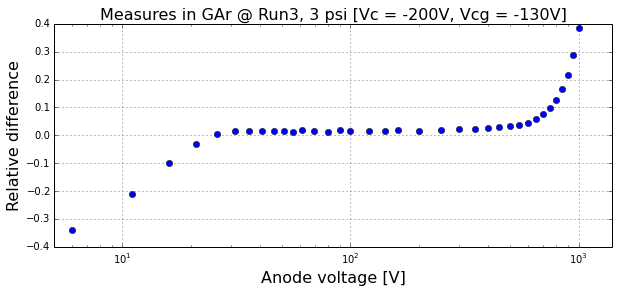

In [159]:
fig = plt.figure(figsize=(10,4))
measure1=[1]
#run1_a=Ta_avg_v
#run1_c=Tc_avg_v
#run1_rms=Tc_rms_v
# gas run2:
#anode_voltages=[30,60,100,150,200,250,300,350,400,450]
# liquid run2:
#anode_voltages=[46,75,100,150,200,250,300,350,400,450,500,600,700,800,900,1000]#RUN2

#cathode_voltages=[62.5,83,103,123,143,200,250,300,350,400,450,500,600,700]
#anode_voltagesRUN1=[13,18,23,34,44,54,103,150,200,300,400,491,600,700,800,900,1000]#RUN1
#run3, gas
anode_voltages=[6,11, 16, 21, 26, 31, 36, 41, 46, 51, 56, 61, 69, 80, 90, 100, 120, 141, 161, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000]
#run3, gas low voltages for cath and cath grid
#anode_voltages=[6, 8,11, 13, 16, 18, 21, 23, 26, 29, 31, 36, 41, 46, 51, 56, 61, 69, 80, 90, 100, 120, 141, 161, 200, 250, 300, 350, 400, 600, 800, 1000]
#plt.plot_date(date_v,np.abs(Qa_avg_v))
#plt.plot_date(date_v,np.abs(Qc_avg_v))
ratio=(np.array(np.abs(int_an_v))-np.array(np.abs(int_cat_v)))/np.array(np.abs(int_cat_v))
err_ratio=np.sqrt((np.array(Qa_rms_v)/(np.array(int_cat_v)))**2+(np.array(int_an_v)*np.array(Qc_rms_v)/(np.array(int_cat_v))**2)**2)
Qa_avg_v=np.array(Qa_avg_v)
Qc_avg_v=np.array(Qc_avg_v)
Qa_rms_v=np.array(Qa_rms_v)
Qc_rms_v=np.array(Qc_rms_v)


print(err_ratio)
#plt.errorbar(anode_voltages,int_an_v,yerr=Qa_rms_v,fmt='o',color='r',label='Anode')
#plt.errorbar(anode_voltages,int_cat_v,yerr=Qc_rms_v,fmt='o',color='b',label='Cathode')

plt.errorbar(anode_voltages,ratio,yerr=err_ratio,fmt='o',color='b',markersize=6)

plt.grid()
plt.legend(numpoints=1,fontsize=18, loc=1)
plt.xlabel('Anode voltage [V]',fontsize=16)
plt.ylabel('Relative difference',fontsize=16)
#plt.ylabel('Ratio delta amplitude / cathode',fontsize=16)
#plt.ylabel('Drift time [ms] [50-run avg.]',fontsize=16)
#plt.ylabel('Amplitude anode / amplitude cathode',fontsize=20)
plt.title('Measures in GAr @ Run3, 3 psi [Vc = -200V, Vcg = -130V]',fontsize=16)
#plt.title('Measures in LAr @ Run1, [Vc = -200V, Vcg = -130V]',fontsize=16)
#plt.title('Drift time in LAr, [Vc = -200V, Vcg = -130V]',fontsize=16)

#fig.savefig('measures_LAr_VC100_VCG65.png')
plt.xlim([5,1400])
plt.ylim([-0.4,0.4])#0.00,0.16])
plt.xscale('log')
plt.show()

In [87]:
def integrale(values_vector, time_vector,b_a,b_c):
    int_anode=0
    int_cathode=0
    
    for index in range (int(0.05/dt), int(0.8/dt)):
        int_anode+=dt*(values_vector[0][index]-b_a)
        #print(int_anode)
        int_cathode+=dt*(values_vector[1][index]-b_c)
    return [int_anode, np.fabs(int_cathode) ]    
        

In [101]:
print(Qa_rms_v)

[  4.52224153e-05   5.80513433e-05   5.59008737e-05   5.50556136e-05
   5.79393161e-05   5.88409541e-05   6.02186483e-05   5.44043159e-05
   5.60393487e-05   6.18220739e-05   5.94264167e-05   5.52992550e-05
   5.42337814e-05   6.24359506e-05   6.13892427e-05   5.31426968e-05
   5.69616304e-05   5.70983968e-05   6.10849042e-05   5.28533951e-05
   5.61902815e-05   5.99857074e-05   5.53515940e-05   6.71354343e-05
   7.14235468e-05   6.31870767e-05   7.05156731e-05   6.80001816e-05
   6.85974403e-05   6.92598253e-05   7.03720582e-05   7.16220007e-05
   7.70363601e-05   8.62862418e-05   9.62798349e-05]


In [144]:

ratio15 = [-1., -0.24668679, -0.11322492, -0.03218646, -0.00058467,  0.00227667,  0.00495479,
  0.00253999,  0.00453614,  0.0042919,   0.00324464 , 0.00371206 , 0.0047085,
  0.00513499,  0.00380238,  0.00591072,  0.00384652 , 0.00380147 , 0.00573098,
  0.00429826,  0.00738685,  0.0080153,   0.00926858 , 0.01277445 , 0.01645522,
  0.01997176,  0.0215852,   0.02366643,  0.02885677 , 0.03140749,  0.03623715,
  0.04104347,  0.04918997,  0.05822755,  0.06981644,  0.08945703]

err_ratio15=[0,0.0014047138520653494, 0.0017420234042780096, 0.001827264127014538, 0.0020222990486805682, 0.001922791107909393, 0.001869023481516259, 0.001995127081191335, 0.001903893273863286, 0.0018970986596561776, 0.001964011643485249, 0.0018990856940196805, 0.0019141599841018435, 0.001961523525386318, 0.001969136307847787, 0.0019687065171791755, 0.0018515507413195016, 0.0020179896773399653, 0.001988526603395771, 0.0018252502485274723, 0.0019163438390570353, 0.0018962516322811667, 0.0018872779222859162, 0.0020410918622035903, 0.0021009931197124958, 0.002120941667365355, 0.0020564847992617175, 0.0020947335873876954, 0.0020406113752734173, 0.0021321073266618203, 0.0022222845254233716, 0.00212720956044876, 0.002167901256932354, 0.002218347532268903, 0.002360185826384608, 0.002563392454039681]

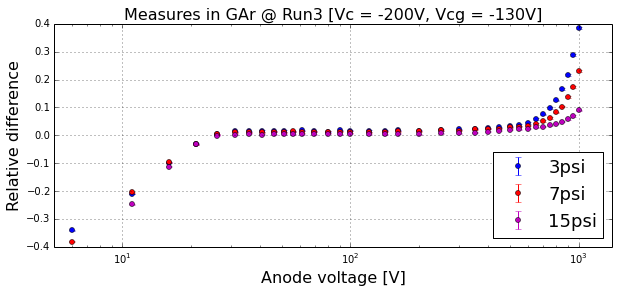

In [149]:
fig = plt.figure(figsize=(10,4))
anode_voltages=[6, 11, 16, 21, 26, 31, 36, 41, 46, 51, 56, 61, 69, 80, 90, 100, 120, 141, 161, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000]
plt.errorbar(anode_voltages,ratio3,yerr=err_ratio3,fmt='o',color='b',markersize=5,label='3psi')
plt.errorbar(anode_voltages,ratio7,yerr=err_ratio7,fmt='o',color='r',markersize=5,label='7psi')
plt.errorbar(anode_voltages,ratio15,yerr=err_ratio15,fmt='o',color='m',markersize=5,label='15psi')
plt.grid()
plt.legend(numpoints=1,fontsize=18, loc=4)
plt.xlabel('Anode voltage [V]',fontsize=16)
#plt.ylabel('Amplitude [mV] [50-run avg.]',fontsize=16)
plt.ylabel('Relative difference',fontsize=16)
#plt.ylabel('Drift time [ms] [50-run avg.]',fontsize=16)
#plt.ylabel('Amplitude anode / amplitude cathode',fontsize=20)
plt.title('Measures in GAr @ Run3 [Vc = -200V, Vcg = -130V]',fontsize=16)
#plt.title('Measures in LAr @ Run1, [Vc = -200V, Vcg = -130V]',fontsize=16)
#plt.title('Drift time in LAr, [Vc = -200V, Vcg = -130V]',fontsize=16)

#fig.savefig('measures_LAr_VC100_VCG65.png')
plt.xlim([5,1400])
plt.ylim([-0.4,0.4])#0.00,0.16])
plt.xscale('log')
plt.show()